Import libraries

In [2]:
import cv2 
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Indicar o caminho do dataset com as imagens originais e onde ficarão armazenadas as imagens modificadas
root_dir = './dataset'
source_dir = os.path.join(root_dir, 'data')
resized_dir = os.path.join(root_dir, 'resized_data')    
hist_dir = os.path.join(root_dir, 'histogram_eq_data')
border_dir = os.path.join(root_dir, 'border_dir')  
segmented_dir = os.path.join(root_dir, 'segmented_dir')   
selected_dir = os.path.join(root_dir, 'selected_data')
selected_dir2 = os.path.join(root_dir, 'selected_data2')
augmented_dir = os.path.join(root_dir, 'augmented_data')
augmented_dir2 = os.path.join(root_dir, 'augmented_data2')

# Realizar o calculo da media dos valores da altura e largura das imagens
# para redimensionar todas imagens para um mesmo tamanho
width = []
height = []

for file in os.listdir(source_dir):
    img_path = os.path.join(source_dir, file)

    image = Image.open(img_path)
    w, h = image.size

    width.append(w)
    height.append(h)

width_mean = sum(width) / len(width)
height_mean = sum(height) / len(height)

#Só para confirmar a saida dos tamanhos(APAGAR DEPOIS)
print(f"Média de largura: {int(width_mean)}")
print(f"Média de altura: {int(height_mean)}")

width = int(width_mean)
height = int(height_mean)
# Definir a largura e a altura para qual as imagens serão redimensionadas
dim = (width, height)

Média de largura: 3571
Média de altura: 3315


Resizing images

In [3]:
# Criar a pasta para armazenar as imagens redimensionadas (caso nao exista)
if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

# Identificar e redimensionar as imagens seguindo o padrao definido anteriormente
for filename in os.listdir(source_dir):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(source_dir, filename))
        img_resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        cv2.imwrite(os.path.join(resized_dir, filename), img_resized)
    else:
        ...

Histogram equalization

In [4]:
# Converter as imagens para escala de cinza, com o objetivo de simplificar a equalizacao do histograma 
def convert_to_gray(image, luma=False):
    if luma:
        params = [0.299, 0.589, 0.114]
    else:
        params = [0.2125, 0.7154, 0.0721]        
    
    # Saturar os pixels de cores que ultrapassam 255 para 255 (evitar perda de nitidez)
    gray_image = np.ceil(np.dot(image[...,:3], params))
    gray_image[gray_image > 255] = 255
    
    return gray_image

# Iniciar o histograma 
def instantiate_histogram():    
    hist_array= []
    
    for i in range(0,256):
        hist_array.append(str(i))
        hist_array.append(0)
    
    hist_dct = {hist_array[i]: hist_array[i + 1] for i in range(0, len(hist_array), 2)} 
    
    return hist_dct

# Contagem da quantidade de vezes que cada valor de intensidade aparece na imagem
def count_intensity_values(hist, img):
    for row in img:
        for column in row:
            hist[str(int(column))] = hist[str(int(column))] + 1
     
    return hist

# Calcular a probabilidade dividindo a quantidade de  vezes que o valor apareceu
# pelo número total de pixels na imagem
def get_hist_proba(hist, n_pixels):
    hist_proba = {}
    for i in range(0, 256):
        hist_proba[str(i)] = hist[str(i)] / n_pixels
    
    return hist_proba

# Calcular a probabilidade acumulada onde cada iteração o valor do histograma é somado 
# à probabilidade acumulada das iterações anteriores
def get_accumulated_proba(hist_proba): 
    acc_proba = {}
    sum_proba = 0
    
    for i in range(0, 256):
        if i == 0:
            pass
        else: 
            sum_proba += hist_proba[str(i - 1)]
            
        acc_proba[str(i)] = hist_proba[str(i)] + sum_proba
    
    return acc_proba

# Calcular os novos valores de cinza da imagem
def get_new_gray_value(acc_proba):
    new_gray_value = {}
    
    for i in range(0, 256):
        new_gray_value[str(i)] = np.ceil(acc_proba[str(i)] * 255)
    
    return new_gray_value

# Aplicar a nova escala de cinza nas imagens originais
def equalize_hist(img, new_gray_value):
    for row in range(img.shape[0]):
        for column in range(img.shape[1]):
            img[row][column] = new_gray_value[str(int(img[row] [column]))]
            
    return img


In [5]:
# Criar a pasta para armazenar as imagens equalizadas (caso nao exista)
if not os.path.exists(hist_dir):
    os.makedirs(hist_dir)

# Aplicar a todas as imagens já redimensionadas, o histograma equalizado
for filename in os.listdir(resized_dir):
    img = cv2.imread(os.path.join(resized_dir, filename))
    img = convert_to_gray(img, False)

    histogram = instantiate_histogram()
    histogram = count_intensity_values(histogram, img)

    n_pixels = img.shape[0] * img.shape[1]
    hist_proba = get_hist_proba(histogram, n_pixels)

    accumulated_proba = get_accumulated_proba(hist_proba)

    new_gray_value = get_new_gray_value(accumulated_proba)

    #Aplicar o filtro Gaussiano para eliminação de ruidos na imagem

    imagem_denoised = cv2.GaussianBlur(img, (5, 5), 0)

    # Salvar na pasta criada anteriormente as novas imagens equalizadas
    eq_img = equalize_hist(img.copy(), new_gray_value)
    cv2.imwrite(os.path.join(hist_dir, filename), eq_img)

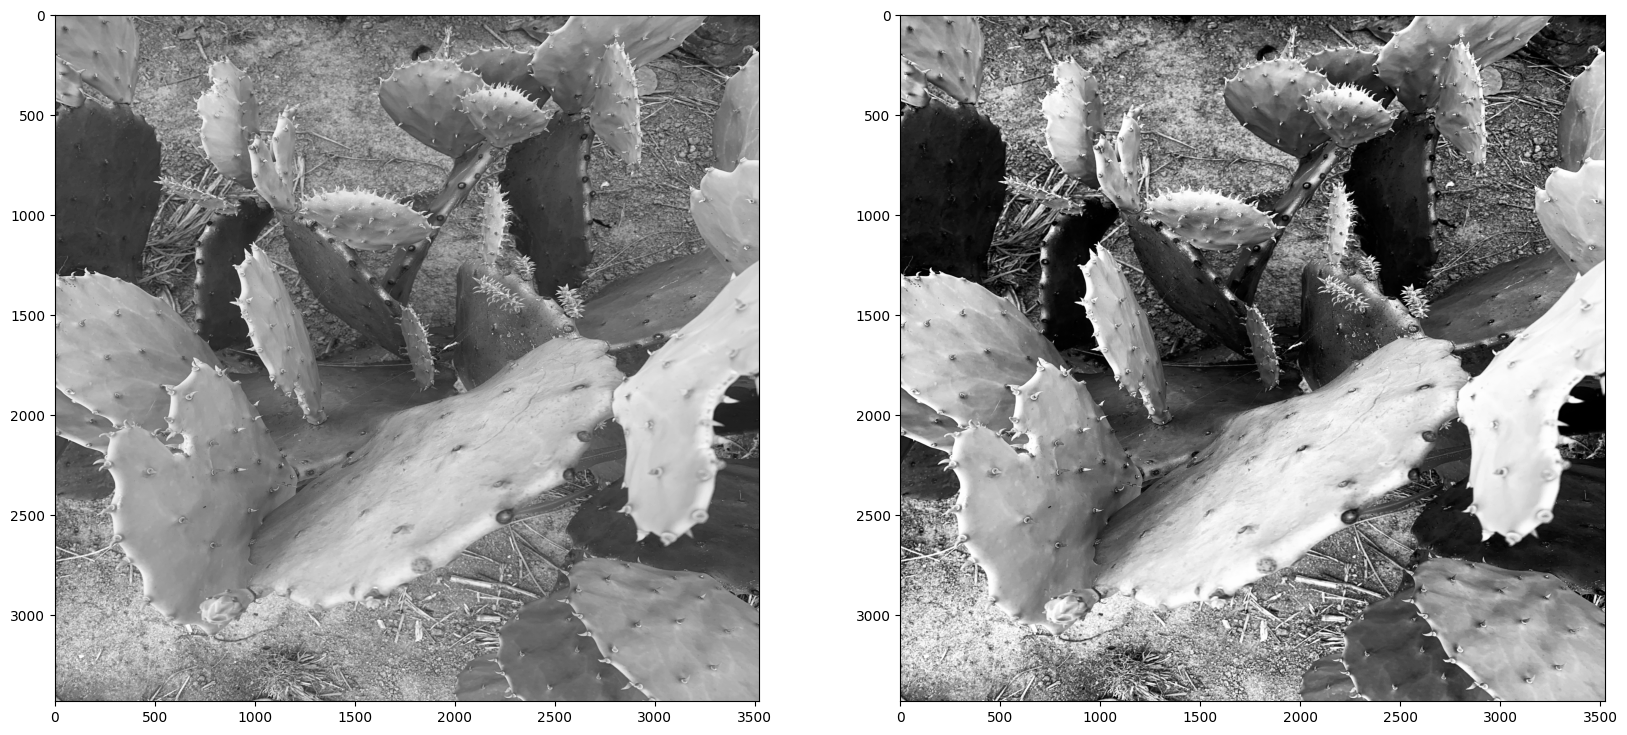

In [7]:
# Plotar imagens em escala de cinza x escala de cinza equalizadas
figure, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(eq_img, cmap='gray')

In [26]:
# Criar a pasta para armazenar as bordas das imagens caso nao exista)
if not os.path.exists(border_dir):
    os.makedirs(border_dir)
    
# Extrair as bordas das imagens equalizadas
for filename in os.listdir(hist_dir):
    img2 = os.path.join(hist_dir, filename)
    gray_images = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
    border_images = cv2.Canny(gray_images, 150, 200)

    cv2.imwrite(os.path.join(border_dir, filename), border_images)

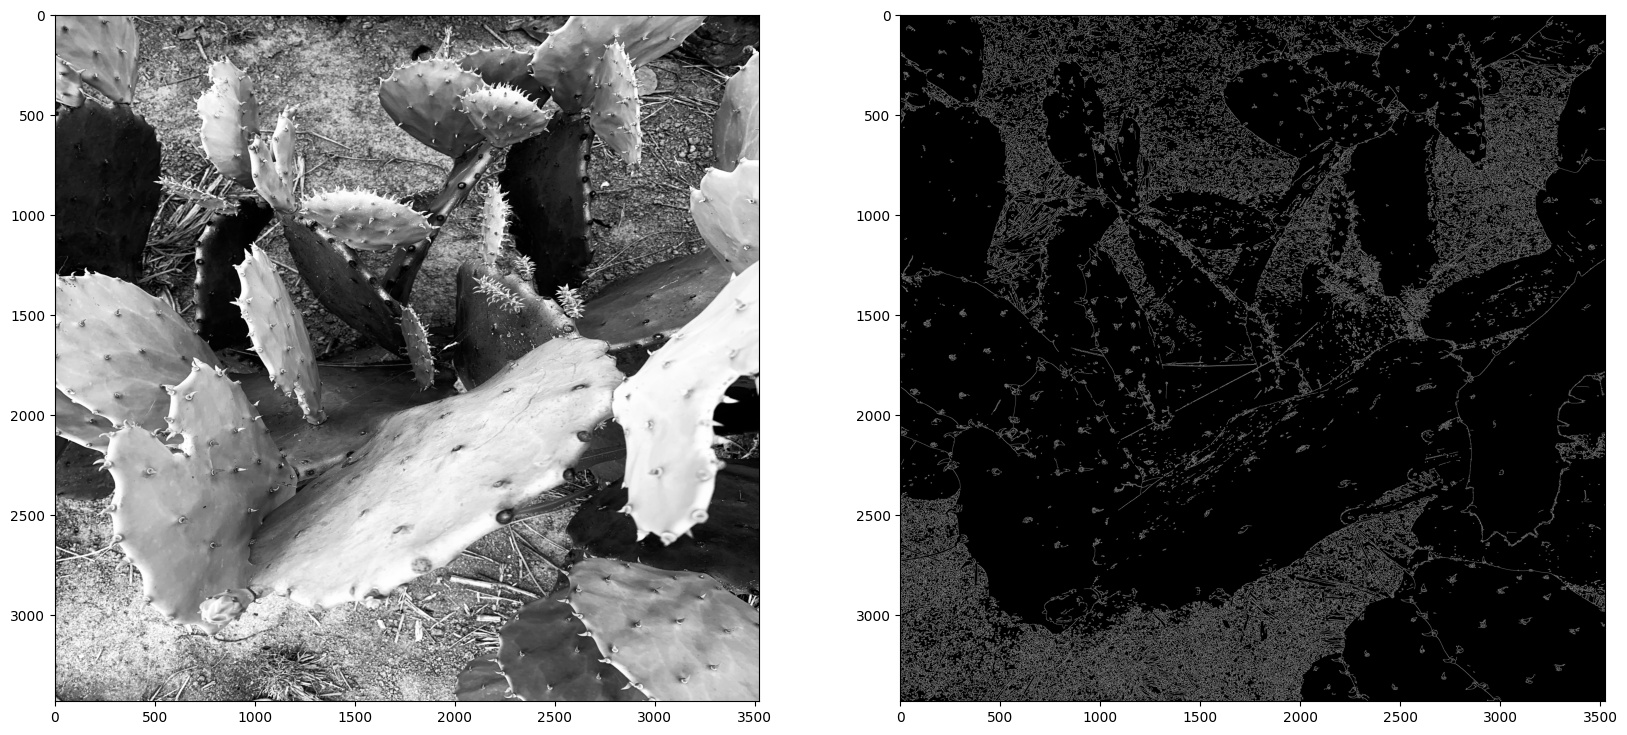

In [18]:
# Plotar imagens em escala de cinza x escala de cinza equalizadas
figure, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(eq_img, cmap='gray')
axarr[1].imshow(border_images, cmap='gray')

Segmentação da imagem

In [21]:
# Criar a pasta para armazenar as imagens segmentadas caso nao exista)
if not os.path.exists(segmented_dir):
    os.makedirs(segmented_dir)
        
for filename in os.listdir(resized_dir):

    img = cv2.imread(os.path.join(resized_dir, filename))

    # Converter a imagem de RGB para HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Definir intervalo de verde para criar a máscara
    lower = np.array([30, 10, 10])  # Verde mais escuro
    upper = np.array([80, 200, 200])# Verde mais claro

    # Criar uma máscara usando o intervalo de cor
    mask = cv2.inRange(img_hsv, lower, upper)

    # Aplicar a máscara à imagem original
    imageSegmented = cv2.bitwise_and(img, img, mask=mask)

    # Salvar na pasta criada anteriormente as novas imagens segmentadas
    cv2.imwrite(os.path.join(segmented_dir, filename), imageSegmented)   

Augmentar o dataset segmentado

In [3]:
def change_brightness_contrast(image, alpha, beta):
    
    # Aplicar a transformação linear para alterar brilho e contraste
    result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return result

for filename in os.listdir(selected_dir):

    imageSelected = cv2.imread(os.path.join(selected_dir, filename))

    # Definir os parâmetros de brilho e contraste desejados
    alpha = 1.15  # Fator de contraste (1.0 significa sem alteração)
    beta = -15    # Fator de brilho

    # Alterar brilho e contraste
    modifiedImage = change_brightness_contrast(imageSelected, alpha, beta)

    # Exibir as imagens original e alterada
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite(os.path.join(augmented_dir, filename), modifiedImage)

Augmentar as imagens originais

In [4]:
def change_brightness_contrast(image, alpha, beta):
    
    # Aplicar a transformação linear para alterar brilho e contraste
    result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return result

for filename in os.listdir(selected_dir2):

    imageSelected2 = cv2.imread(os.path.join(selected_dir2, filename))

    # Definir os parâmetros de brilho e contraste desejados
    alpha = 1.15 # Fator de contraste (1.0 significa sem alteração)
    beta = 10    # Fator de brilho

    # Alterar brilho e contraste
    modifiedImage = change_brightness_contrast(imageSelected2, alpha, beta)

    # Exibir as imagens original e alterada
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite(os.path.join(augmented_dir2, filename), modifiedImage)